In [171]:
# import os
# import pickle
import sys
# # sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')
sys.path.append('/home/diego/python/generative-glm/experiments/')

import matplotlib as mpl
from matplotlib import ticker
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import numpy as np
import pandas as pd

from experiments.utils.kernels import *
from experiments.utils.plot import plot_errorbar, plot_layout_fit
import myplt
from utils import *

# import h5py
from gglm.glm.mmdglm import MMDGLM
# from gglm.metrics import bernoulli_log_likelihood_poisson_process
# from kernel.values import KernelBasisValues
# from signals import auto_covariance
# from sptr.sptr import SpikeTrain

%load_ext autoreload
%autoreload 2

# import seaborn as sns
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='tab:blue', ml='#2ca02c', mmd='C1', l2='C8')    
ms, mew, capsize= 20, 1.5, 5

mmd_fits_colors = ['C1', 'C3', 'C4', 'C5', 'C6', 'C7', 'C9']

# root_folder = '/home/diego/Dropbox/generative_glm/figures/huk/'
# files_folder = '/home/diego/storage/generative-glm/experiments/figure4/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
def define_broken_plot_lims(ax, ya, yb):
    ax[0].set_ylim(ya)
    ax[1].set_ylim(yb)

In [93]:
path = "./huk_p110509b_dots.h5"

files_folder = '/home/diego/storage/projects/generative-glm/experiments/figure4/'

idx_train = np.arange(100, 200, 2)
idx_val = idx_train + 1

argf_autocorr = 250
bins_isi = np.arange(0, 1091, 1)

from kernel.fun import KernelFun
sd2 = 1e2
ker = KernelFun.gaussian_delta(sd2)

dt, t, st_train, fr_train, isi_train, autocor_train, nll_pois_proc_train, n_spk_train, cum_train, st_val, fr_val, isi_val, autocor_val, nll_pois_proc_val, n_spk_val, cum_val = load_data(path="./huk_p110509b_dots.h5", 
                                                                                                       idx_train=idx_train, idx_val=idx_val, bins_isi=bins_isi)
fr_val = np.sum(st_val.mask, 0) / (dt * st_val.mask.shape[0]) * 1000
conv_val = np.mean(ker.convolve_continuous(t, st_val.mask), 1)

files_folder = '/home/diego/storage/projects/generative-glm/experiments/figure4/'
ml_file = 'mln5.pk'
l2_file = 'l2n5.pk'
n, last_peak = 5, 100
dt = 1

div_cutoff = 50

glm_ml, nll_normed_train_ml, nll_normed_val_ml, bins_ks, r_train_dc_ml, r_val_dc_ml, r_fr_ml, mask_spikes_fr_ml, st_fr_ml, isi_fr_ml, autocor_ml, z_ml_val, ks_ml_val, z_cum_ml_val = load_ml(files_folder + ml_file, dt, st_train, st_val)
fr_ml = np.sum(mask_spikes_fr_ml, 0) / (dt * mask_spikes_fr_ml.shape[0]) * 1000
p_divergent_ml = np.sum(fr_ml > div_cutoff) / len(fr_ml)
g_ml = np.exp(glm_ml.u0) * 1000
eta_vals_ml = np.exp(np.dot(glm_ml.eta.basis_values, glm_ml.eta.coefs))
autocor_mse_ml = np.mean((autocor_ml[1:argf_autocorr] - autocor_val[1:argf_autocorr])**2)
history_mse_ml = np.mean((np.mean(np.log(r_val_dc_ml) - glm_ml.b.detach().numpy(), 1) - np.mean(np.log(r_fr_ml) - glm_ml.b.detach().numpy(), 1))**2)
mu_isi_ml, cv_isi_ml = np.mean(isi_fr_ml), np.std(isi_fr_ml) / np.mean(isi_fr_ml)
cum_ml = cum_isi(isi_fr_ml, bins=bins_isi)
ks_cum_ml = np.max(np.abs(cum_ml - cum_val))
conv_ml = np.mean(ker.convolve_continuous(t, mask_spikes_fr_ml), 1)
psth_mse_ml = np.mean((conv_ml - conv_val)**2)

glm_l2, nll_normed_train_l2, nll_normed_val_l2, r_train_dc_l2, r_val_dc_l2, r_fr_l2, mask_spikes_fr_l2, st_fr_l2, isi_fr_l2, autocor_l2 = load_l2(files_folder + l2_file, dt, st_train, st_val)
fr_l2 = np.sum(mask_spikes_fr_l2, 0) / (dt * mask_spikes_fr_l2.shape[0]) * 1000
p_divergent_l2 = np.sum(fr_l2 > div_cutoff) / len(fr_l2)
g_l2 = np.exp(glm_l2.u0) * 1000
eta_vals_l2 = np.exp(np.dot(glm_l2.eta.basis_values, glm_l2.eta.coefs))
autocor_mse_l2 = np.mean((autocor_l2[1:argf_autocorr] - autocor_val[1:argf_autocorr])**2)
cv_isi_l2 = np.std(isi_fr_l2) / np.mean(isi_fr_l2)
cum_l2 = cum_isi(isi_fr_l2, bins=bins_isi)
ks_cum_l2 = np.max(np.abs(cum_l2 - cum_val))

t_ker = np.arange(0, glm_ml.eta.basis_values.shape[0], 1) * dt

## figure

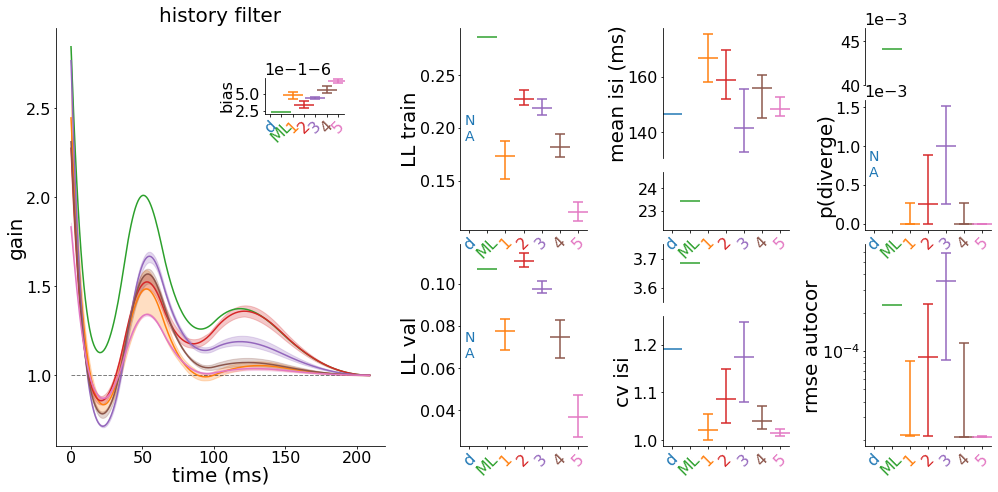

In [246]:
whis = [5, 95]
lw_eta = 1.5
widths = 0.5

fig, (axeta, axbias, axll_train, axmuisi, axlabels, axci, axll_val, axmuisi, axcv, axac, ax11, axpdiv, ax3, ax4) = plot_layout_fig4(figsize=(24, 7.7))

fig.subplots_adjust(hspace=1.5, wspace=0.6)

# axcv = axmuisi
# axac = axmuisi

t_ker = np.arange(0, glm_ml.eta.basis_values.shape[0], 1)

# myplt.set_labels(axbias, xlabel='', ylabel='exp(b) (Hz)')
# axbias.set_yticks([0, 2, 4])
# axbias.set_yticks([0, 5e-3])
# axins1.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=False)
# axbias.tick_params(axis='both', labelsize=12)
# axbias.set_ylim(-5e-3, 1e-2)

axeta.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', alpha=0.5, lw=1)
# axeta.set_xscale('log')

# yfr_0a = 50
# # axfra.set_yticks([])
# axfra.set_ylim(yfr_0a, 1000)
# axfra.set_yscale('log')
# axfra.get_yaxis().set_minor_formatter(ticker.NullFormatter())

# yfr_fb = 25
# # myplt.set_labels(axfrb, ylabel='firing rate (Hz)')
# axfrb.set_ylim(-0.5, yfr_fb)
# axfrb.yaxis.set_label_coords(-0.4, 0.9)
    
# define_broken_plot_lims(axcv, [3, 4], [1, 1.25])
    
x0 = -0.5

## DATA

# violinplot(axmuisi, isi_val, 0, widths=widths, showmeans=True, color=palette['d'])
axmuisi[0].errorbar(0, np.mean(isi_val), fmt='_', color=palette['d'], ms=ms, mew=mew, capsize=capsize)

# axcv.bar(0, np.std(isi_val) / np.mean(isi_val), color=palette['d'])
# axcv.errorbar(0, np.std(isi_val) / np.mean(isi_val), color=palette['d'], ms=ms, mew=mew, capsize=capsize)

axcv[1].errorbar(0, np.std(isi_val) / np.mean(isi_val), fmt='_', color=palette['d'], ms=ms, mew=mew, capsize=capsize)

axac.errorbar(0, 0, fmt='_', color=palette['d'], ms=ms, mew=mew, capsize=capsize)

def plot_bar(ii, x, ax, color):
    if x[1] is None:
        ax.bar(ii, x[0], color=color)
    else:
        ax.bar(ii, x[0], color=color, yerr=np.array([x[1], x[2]])[:, None])
        

def plot_errorbar(ii, x, ax, color, **kwargs):
    if x[1] is None:
        ax.errorbar(ii, x[0], color=color, fmt='_', **kwargs)
    else:
        ax.errorbar(ii, x[0], color=color, yerr=np.array([x[1], x[2]])[:, None], fmt='_', **kwargs)
        
def plot_observables(ii=None, g=None, eta_vals=None, ll_train=None, ll_val=None, fr=None, isi=None, p_divergent=None, mu_isi=None, cv_isi=None, ks_cum=None, 
                     autocor_mse=None, history_mse=None, grad_cv=None, psth_mse=None, color=None, broken=None):
        
    plot_errorbar(ii, g, ax=axbias, color=color, ms=ms, mew=mew, capsize=capsize)

    if eta_vals[0] is not None:
        axeta.plot(t_ker, eta_vals[0], color=color, lw=lw_eta)
    
    if eta_vals[1] is not None:
        axeta.fill_between(t_ker, eta_vals[1], eta_vals[2], color=color, alpha=0.25)

#     cv_isi = np.std(isi) / np.mean(isi)

#     _, r_fr, mask_spikes_fr = glm.sample(st_val.t, shape=(8000,))
#     fr = np.sum(mask_spikes_fr_ml, 0) / (mask_spikes_fr.shape[0] * dt) * 1000
#     autocor = np.mean(raw_autocorrelation(mask_spikes_fr, biased=True), 1)

#     axll_train.bar(ii, ll_train, color=color)
#     if ll_train[1] is None:
#         axll_train.bar(ii, ll_train[0], color=color)
#     else:
#         axll_train.bar(ii, ll_train[0], color=color, yerr=np.array([ll_train[1], ll_train[2]])[:, None])
        
    plot_errorbar(ii, ll_train, ax=axll_train, color=color, ms=ms, mew=mew, capsize=capsize)
    plot_errorbar(ii, ll_val, ax=axll_val, color=color, ms=ms, mew=mew, capsize=capsize)
    
#     axfra.boxplot(fr, positions=[ii], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
#                           boxprops=dict(facecolor=color), 
#                           meanprops=dict(color='k'), 
#                           medianprops=dict(color='k'))
#     axfrb.boxplot(fr, positions=[ii], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
#                           boxprops=dict(facecolor=color), 
#                           meanprops=dict(color='k'), 
#                           medianprops=dict(color='k'), whis=whis)
    
#     violinplot(axmuisi, isi, ii, widths=widths, showmeans=True, color=color)

    if broken is None:
        plot_errorbar(ii, mu_isi, ax=axmuisi[0], color=color, ms=ms, mew=mew, capsize=capsize)
    else:
        axi = broken.get('mu', 1)
        plot_errorbar(ii, mu_isi, ax=axmuisi[axi], color=color, ms=ms, mew=mew, capsize=capsize)
    
    if broken is None:
        plot_errorbar(ii, cv_isi, ax=axcv[1], color=color, ms=ms, mew=mew, capsize=capsize)
    else:
        axi = broken.get('cv', 0)
        plot_errorbar(ii, cv_isi, ax=axcv[axi], color=color, ms=ms, mew=mew, capsize=capsize)

    plot_errorbar(ii, autocor_mse, ax=axac, color=color, ms=ms, mew=mew, capsize=capsize)
#     if broken is None:
#         plot_errorbar(ii, autocor_mse, ax=axac[1], color=color, ms=ms, mew=mew, capsize=capsize)
#     else:
#         axi = broken.get('ac', 0)
#         plot_errorbar(ii, autocor_mse, ax=axac[axi], color=color, ms=ms, mew=mew, capsize=capsize)
    
    if broken is None:
        plot_errorbar(ii, p_divergent, ax=axpdiv[1], color=color, ms=ms, mew=mew, capsize=capsize)
    else:
        axi = broken.get('pdiv', 0)
        plot_errorbar(ii, p_divergent, ax=axpdiv[axi], color=color, ms=ms, mew=mew, capsize=capsize)

# p0, pf = 2.5, 97.5
# p0, pf = 0, 100
p0, pf = 5, 95
# p0, pf = 25, 75
# p0, pf = 49, 51
def mean_error(x):
    xm = np.percentile(x, 50, axis=-1)
    x0 = xm - np.percentile(x, p0, axis=-1)
    xf = np.percentile(x, pf, axis=-1) - xm
    return xm, x0, xf
    
def get_observables(pk_f):
    jj = ii + 3
    with open(files_folder + pk_f, "rb") as fit_file:
        pk = pickle.load(fit_file)
    u0_m = np.mean(pk['u0'])
    
#     g0_m = np.exp(u0_m) * 1000
#     g0_0 = g0_m - np.exp(np.percentile(pk['u0'], p0)) * 1000
#     g0_f = np.exp(np.percentile(pk['u0'], pf)) * 1000 - g0_m
    
    g0_m = u0_m
    g0_0 = g0_m - np.percentile(pk['u0'], p0)
    g0_f = np.percentile(pk['u0'], pf) - g0_m
    
    eta_coefs_m = np.mean(pk['eta_coefs'], 1)
    ll_train = pk['ll_train']
    ll_val = pk['ll_val']
    fr_mmd = pk['fr_m']
    p_divergent = pk['p_divergent']
    ks_cum = pk['ks_cum']
    
#     fr_mmd = fr_mmd.reshape(-1)
    mu_isi, cv_isi = pk['mu_isi'], pk['cv_isi']
    autocor_mse = pk['autocor_mse']
    history_mse = pk['history_mse']
    grad_cv = pk['grad_cv']
    psth_mse = pk['psth_mse']
    
    ll_train_m, ll_train_0, ll_train_f = mean_error(ll_train)
    
    ll_val_m, ll_val_0, ll_val_f = mean_error(ll_val)
#     fr_m, fr_0, fr_f = mean_error(fr_m)
    autocor_mse_m, autocor_mse_0, autocor_mse_f = mean_error(np.sqrt(autocor_mse))
    mu_isi = mean_error(mu_isi)
    cv_isi = mean_error(cv_isi)
    
    eta_vals = np.exp(np.dot(pk['basis'], pk['eta_coefs']))
    eta_vals_m = np.mean(eta_vals, axis=1)
    eta_vals_0 = np.percentile(eta_vals, p0, axis=1)
    eta_vals_f = np.percentile(eta_vals, pf, axis=1)
    
    pdiv_m, pdiv_0, pdiv_f = mean_error(p_divergent)
    ks_cum_m, ks_cum_0, ks_cum_f = mean_error(ks_cum)
    history_mse = mean_error(history_mse)
    grad_cv = mean_error(grad_cv)
    psth_mse = mean_error(psth_mse)
    
    eta_mmd = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=eta_coefs_m)
    mmdglm = MMDGLM(u0=u0_m, eta=eta_mmd)
    
    _, _, mask_spikes_fr = mmdglm.sample(t, shape=(8000, ))
#     fr = np.sum(mask_spikes_fr, 0) / (dt * mask_spikes_fr.shape[0]) * 1000
#     isi = SpikeTrain(t, mask_spikes_fr).isi_distribution()
    fr, isi = None, None
#     isi = []
#     for jj in range(3):
#         _, _, mask_spikes_fr = mmdglm.sample(t, shape=(8000, ))
#         fr = np.sum(mask_spikes_fr, 0) / (dt * mask_spikes_fr.shape[0]) * 1000
#         isi = np.append(isi, SpikeTrain(t, mask_spikes_fr).isi_distribution())
    
    return mmdglm, (g0_m, g0_0, g0_f), (eta_vals_m, eta_vals_0, eta_vals_f), (ll_train_m, ll_train_0, ll_train_f), (ll_val_m, ll_val_0, ll_val_f), \
            fr, isi, (pdiv_m, pdiv_0, pdiv_f), (ks_cum_m, ks_cum_0, ks_cum_f), (autocor_mse_m, autocor_mse_0, autocor_mse_f), history_mse, mu_isi, cv_isi, grad_cv, psth_mse
    
plot_observables(ii=1, g=(glm_ml.u0, None, None), eta_vals=(eta_vals_ml, None, None), ll_train=(-nll_normed_train_ml[-1], None, None), 
                 ll_val=(-nll_normed_val_ml[-1], None, None), fr=fr_ml, p_divergent=(p_divergent_ml, None , None), isi=isi_fr_ml, 
                 mu_isi=(mu_isi_ml, None, None), cv_isi=(cv_isi_ml, None, None), 
                 ks_cum=(ks_cum_ml, None, None), grad_cv=(None, None, None), psth_mse=(None, None, None), history_mse=(history_mse_ml, None, None), autocor_mse=(autocor_mse_ml, None, None), color=palette['ml'], 
                 broken={'ac': 1})

# plot_observables(ii=2, g=(g_l2, None, None), eta_vals=(eta_vals_l2, None, None), ll_train=(-nll_normed_train_l2[-1], None, None), 
#                  ll_val=(-nll_normed_val_l2[-1], None, None), fr=fr_l2, p_divergent=(p_divergent_l2, None , None), cv_isi=(cv_isi_l2, None, None), 
#                  ks_cum=(ks_cum_l2, None, None), autocor_mse=(autocor_mse_l2, None, None), color=palette['l2'])


# glm_pp = TorchGLM(u0=np.log(np.mean(np.sum(st_train.mask, 0) / (st_train.mask.shape[0] * dt))))
# g_pp = np.mean(np.sum(st_train.mask, 0) / (st_train.mask.shape[0] * dt))
# ll_train_pp, ll_val_pp, fr_pp, mu_fr_fr, sd_fr_fr, p_divergent, isi_fr, mu_isi_pp, sd_isi_pp, ks_cum_pp, ci_mse, autocor_mse_pp = observables_fig4(glm_pp, n_samples=8000)
# cv_isi_pp = sd_isi_pp / mu_isi_pp
# plot_observables(ii=2, g=(g_pp, None, None), eta_vals=(None, None, None), ll_train=(ll_train_pp, None, None), 
#                  ll_val=(ll_val_pp, None, None), fr=fr_pp, p_divergent=(0, None , None), cv_isi=(cv_isi_pp, None, None), 
#                  ks_cum=(ks_cum_pp, None, None), autocor_mse=(autocor_mse_pp, None, None), color='k')

file_names = [
#              'phi_autocor_initzero_lammmd1000000000.0.pk', 
    
#              'phi_autocor_initzero_lammmd1000000000.0_nbatch400.pk', 
             'phi_autocor_initzero_lammmd3000000000.0_nbatch100.pk', 
#              'phi_autocor_initzero_lammmd5000000000.0_nbatch100.pk', 
    
#               'phi_psth_initzero_lammmd100000.0.pk', 
#              'phi_psth_initzero_lammmd50.0.pk', 
              'phi_psth_initzero_lammmd30000.0_nbatch100.pk', 
#               'phi_psth_initzero_lammmd50000.0_nbatch100.pk', 
#               'phi_psth_initzero_lammmd80000.0_nbatch100.pk', 
    
             'phi_mean_history_initzero_lammmd10000.0_nbatch100.pk', 
#              'phi_mean_history_initzero_lammmd200000.0_nbatch100.pk', 
    
#              'phi_autocor_history_initzero_lammmd1000.0_nbatch100.pk',
             'phi_autocor_history_initzero_lammmd4000.0_nbatch100.pk',
#              'phi_autocor_history_initzero_lammmd8000.0_nbatch100.pk',
#              'phi_autocor_history_initzero_lammmd10000.0_nbatch100.pk', 
             'phi_autocor_history_initzero_lammmd30000.0_nbatch100.pk'
             ]

# broken_fits = [None, {'mu': 0, 'cv': 1, 'pdiv': 1}, None, None, None]
broken_fits = [None, None, None, None, None, None, None]
for ii, file_name in enumerate(file_names):
    
    mmdglm, g, eta_vals, ll_train, ll_val, fr, isi, p_div, ks_cum, autocor_mse, history_mse, mu_isi, cv_isi, grad_cv, psth_mse = get_observables(file_name)
    
    plot_observables(ii=ii + 2, g=g, eta_vals=eta_vals, ll_train=ll_train, ll_val=ll_val, fr=fr, p_divergent=p_div, 
                     isi=isi, mu_isi=mu_isi, cv_isi=cv_isi, ks_cum=ks_cum, autocor_mse=autocor_mse, history_mse=history_mse, psth_mse=psth_mse, grad_cv=grad_cv, 
                     color=mmd_fits_colors[ii], broken=broken_fits[ii])
#     break

# axac[1].set_yticks([2e-5])
    
# axac[0].set_yscale('log')
# axac[1].set_yscale('log')

# axac[0].set_yticks([])

# axlabels.set_ylabel('grad cv')
# axci[1].set_ylabel('history')

for ax in (axbias, axll_train, axll_val, axmuisi[1], axcv[1], axac, axpdiv[1]):
    ax.set_xlim(-0.5, ii + 2.5)
    ax.set_xticks(np.arange(ii + 3))
    ax.set_xticklabels(['d', 'ML', '1', '2', '3', '4', '5'], rotation=45)
    for xtick, color in zip(ax.get_xticklabels()[2:], mmd_fits_colors):
        xtick.set_color(color)
    ax.get_xticklabels()[0].set_color(palette['d'])
    ax.get_xticklabels()[1].set_color(palette['ml'])

for ax in (axll_train, axll_val, axpdiv[1]):
#     ax.text(0.1, 0.5, 'N\nA', color=palette['d'], fontsize=14, horizontalalignment='center', 
#             verticalalignment='center', transform=ax.transAxes)
    ax.text(0, (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2, 'N\nA', color=palette['d'], fontsize=14, horizontalalignment='center', 
            verticalalignment='center')

axbias.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=-6)
    
# axac[0].ticklabel_format(axis="y", style="sci", scilimits=(-4,-4), useOffset=False)
# axac[1].ticklabel_format(axis="y", style="sci", scilimits=(-4,-4), useOffset=False)
# axci[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=False)
# axci[1].ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=False)
axac.set_yscale('log')

axcv[0].set_yticks([3.6, 3.7])
axcv[0].set_ylim([3.55, 3.75])

axpdiv[0].set_yticks([0.040, 0.045])
# axpdiv[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=0.04)
axpdiv[0].ticklabel_format(axis="y", style="sci", scilimits=(-3,-3), useOffset=False)
axpdiv[1].ticklabel_format(axis="y", style="sci", scilimits=(-3,-3), useOffset=False)
# axpdiv[0].set_yscale('log')
    
# axpdiv[1].get_yaxis().set_minor_formatter(ticker.NullFormatter())
    
fig.subplots_adjust(hspace=0.25)

fig.savefig('./fig4.pdf', transparent=True, bbox_inches='tight')
fig.savefig('./fig4.svg', transparent=True, bbox_inches='tight')

phi_autocov_initzero_lammmd1000000000.0.pk
- score function

### compile repetitions in one file

In [139]:
def observables_fig4(model, row=None, n_samples=8000):
    mask_spikes_train = st_train.mask.copy()
    mask_spikes_val = st_val.mask.copy()
    u_dc_train, r_dc_train = model.sample_conditioned(t, mask_spikes_train)
    u_dc_val, r_dc_val = model.sample_conditioned(t, mask_spikes_val)
    u_fr, r_fr, mask_spikes_fr = model.sample(t, shape=(n_samples,))

    st_fr = SpikeTrain(t, mask_spikes_fr)
    isi_fr = st_fr.isi_distribution()
    cum_fr = cum_isi(isi_fr, bins=bins_isi)
    ks_cum_fr = np.max(np.abs(cum_fr - cum_val))
    
    mu_isi_fr = np.mean(isi_fr)
    sd_isi_fr = np.std(isi_fr)
    
#     ll_train = np.sum(np.log(1 - np.exp(-dt * r_dc_train[mask_spikes_train]) + 1e-24) ) - \
#                 dt * np.sum(r_dc_train[~mask_spikes_train])
#     ll_train = (ll_train - nll_pois_proc_train) / np.log(2) / n_spk_train
    if row is not None:
        ll_train = -row.nll_normed_train
        ll_val = -row.nll_normed_val_mmd
    else:
        ll_train = 0
        ll_val = 0
#     ll_val = np.sum(np.log(1 - np.exp(-dt * r_dc_val[mask_spikes_val]) + 1e-24) ) - \
#                 dt * np.sum(r_dc_val[~mask_spikes_val])
#     ll_val = (ll_val - nll_pois_proc_val) / np.log(2) / n_spk_val

    fr = np.sum(mask_spikes_fr, 0) / (dt * mask_spikes_fr.shape[0]) * 1000
    p_divergent = np.sum(fr > div_cutoff) / len(fr)
    mu_fr_fr = np.mean(fr)
    sd_fr_fr = np.std(fr)
    autocor_fr = np.mean(raw_autocorrelation(mask_spikes_fr, biased=True), 1)
    
    autocor_mse = np.mean((autocor_fr[1:argf_autocorr] - autocor_val[1:argf_autocorr])**2)
#     ci_mse = np.mean((np.mean(r_dc_val, 1) - np.mean(r_fr, 1))**2)
    history_mse = np.mean((np.mean(np.log(r_dc_val) - model.b.detach().numpy(), 1) - np.mean(np.log(r_fr) - model.b.detach().numpy(), 1))**2)
    conv_fr = np.mean(ker.convolve_continuous(t, mask_spikes_fr), 1)
    psth_mse = np.mean((conv_fr - conv_val)**2)
    
    return ll_train, ll_val, fr, mu_fr_fr, sd_fr_fr, p_divergent, isi_fr, mu_isi_fr, sd_isi_fr, ks_cum_fr, history_mse, autocor_mse, psth_mse

In [216]:
n_samples = 8000

# ker_name = 'phi_autocov'
# initialization, lr, lam_mmd = 'zero', 1e-2, 1e9
# num_epochs, n_batch_fr = 400, 800
# biased = True
# beta0, beta1 = 0.95, 0.99
# padding = 250

# ker_name = 'phi_autocor'
# initialization, lr = 'zero', 1e-2
# biased = True
# beta0, beta1 = 0.95, 0.99
# padding = 250
# # lam_mmd, n_batch_fr, num_epochs = 1e9, 400, 400
# lam_mmd, n_batch_fr, num_epochs = 3e9, 100, 400
# lam_mmd, n_batch_fr, num_epochs = 5e9, 100, 400

# ker_name = 'phi_psth'
# initialization, lr = 'zero', 1e-2
# biased = True
# beta0, beta1 = 0.8, 0.9
# padding= 100
# # lam_mmd, n_batch_fr, num_epochs = 1e5, 800, 400
# # lam_mmd, n_batch_fr, num_epochs = 5e4, 100, 400
# lam_mmd, n_batch_fr, num_epochs = 3e4, 100, 400

# ker_name = 'phi_mean_fr'
# initialization, lr, lam_mmd = 'zero', 3e-2, 1e3
# num_epochs, n_batch_fr = 400, 800
# biased = True
# beta0, beta1 = 0.9, 0.95
# padding= None

# ker_name = 'phi_autocor_history'
# initialization, lr = 'zero', 1e-2, 
# biased = True
# beta0, beta1 = 0.9, 0.95
# padding = 250
# # lam_mmd, n_batch_fr, num_epochs = 1e3, 100, 400
# # lam_mmd, n_batch_fr, num_epochs = 8e3, 100, 400
# # lam_mmd, n_batch_fr, num_epochs = 4e3, 100, 400
# # lam_mmd, n_batch_fr, num_epochs = 2e3, 40, 400
# # lam_mmd, n_batch_fr, num_epochs = 1e4, 100, 400
# lam_mmd, n_batch_fr, num_epochs = 3e4, 100, 400

ker_name = 'phi_mean_history'
initialization, lr, biased = 'zero', 1e-2, True
beta0, beta1 = 0.9, 0.95
padding=None
# lam_mmd, n_batch_fr, num_epochs = 5e6, 100, 600
lam_mmd, n_batch_fr, num_epochs = 1e4, 100, 400
# lam_mmd, n_batch_fr, num_epochs = 2e5, 100, 400

sample = False

df = pd.read_json('mmd_summary_last2.json')
df = df[df.n_basis == 5]
data = df.copy()
data = data[data.ker_name == ker_name]
data = data[(data.initialization == initialization) & (data.lr == lr)]
data = data[(data.lam_mmd == lam_mmd) & (data.biased == biased)]
data = data[(data.num_epochs == num_epochs) & (data.n_batch_fr == n_batch_fr)]
data = data[((data.beta0 - beta0).abs() < 1e-3) & ((data.beta1 - beta1).abs() < 1e-3)]

if padding is not None:
    data = data[data.kernel_kwargs.str[0] == padding]

ll_train, ll_val = [], []
autocor_mse = []
u0, eta_coefs = [], []
fr_m, mu_isi, cv_isi = [], [], []
p_divergent = []
history_mse = []
ks_cum = []
grad_cv = []
psth_mse = []

for idx, row in data.iterrows():
    a, b = idx, row
    break
    
print('number of optimizations is', len(data))

if len(data) > 20:
    data = data.sample(n=20)

for idx, row in data.iterrows():
    
    pkf = row.file_name
    _idx_train = row.idx_train
    _idx_val = row.idx_val
    
    try:
        dic, ker_name, loss_mmd, mmdi, nll_normed_train_mmd, glm, autocor_mmd = load_file(files_folder + pkf, t=t)
        grad_mean, grad_cov = row.params_grad_mean, row.params_grad_cov
        _grad_cv = np.mean(np.abs(grad_mean) / np.sqrt(np.diag(grad_cov)))

        if np.all(_idx_train == idx_train) and np.all(_idx_val == idx_val):

            u0.append(glm.u0)
            eta_coefs.append(glm.eta.coefs)

            if 'll_train' not in dic.keys() or sample:
                _ll_train, _ll_val, fr, mu_fr_fr, sd_fr_fr, _p_divergent, isi_fr, mu_isi_fr, sd_isi_fr, _ks_cum_fr, _history_mse, _autocor_mse, _psth_mse = observables_fig4(glm, row, n_samples=n_samples)
                cv = sd_isi_fr / mu_isi_fr
                dic['ll_train'], dic['ll_val'] = _ll_train, _ll_val
                dic['fr'], dic['cv'] = fr, cv
                dic['ks_cum'], dic['p_divergent'] = _ks_cum_fr, _p_divergent
                dic['history_mse'] = _history_mse
                dic['autocor_mse'] = _autocor_mse
                dic['psth_mse'] = _psth_mse
                with open(files_folder + pkf, "wb") as file:
                    pickle.dump(dic, file)
            else:
                _ll_train, _ll_val = dic['ll_train'], dic['ll_val']
                fr, cv = dic['fr'], dic['cv']
                _ks_cum_fr, _p_divergent = dic['ks_cum'], dic['p_divergent']
                _history_mse = dic['history_mse']
                _autocor_mse = dic['autocor_mse']

            ll_train.append(_ll_train)
            ll_val.append(_ll_val)
            fr_m.append(fr)
            mu_isi.append(mu_isi_fr)
            cv_isi.append(cv)
            ks_cum.append(_ks_cum_fr)
            p_divergent.append(_p_divergent)
            autocor_mse.append(_autocor_mse)
            history_mse.append(_history_mse)
            grad_cv.append(_grad_cv)
            psth_mse.append(_psth_mse)
    except:
        pass

#     break
    
file_name = ker_name + '_init' + initialization + '_lammmd' + str(lam_mmd) + '_nbatch' + str(n_batch_fr) + '.pk'
print(file_name)
    
eta_coefs = np.stack(eta_coefs, 1)
fr_m = np.stack(fr_m, 1)

eta = KernelBasisValues.orthogonalized_raised_cosines(1, last_peak, n, 5e1, a=1, coefs=np.mean(eta_coefs, 1))
glm = MMDGLM(u0=np.mean(u0), eta=eta)

dic_all = dict(basis=glm.eta.basis_values, u0=u0, eta_coefs=eta_coefs, ll_train=ll_train, ll_val=ll_val, fr_m=fr_m, p_divergent=p_divergent, 
               mu_isi=mu_isi, cv_isi=cv_isi, ks_cum=ks_cum, 
               autocor_mse=autocor_mse, history_mse=history_mse, grad_cv=grad_cv, psth_mse=psth_mse)

with open(files_folder + file_name, "wb") as fit_file:
    pickle.dump(dic_all, fit_file)

number of optimizations is 55


<ipython-input-216-faa2ed6bbf49>:97: RuntimeWarning: invalid value encountered in true_divide
  _grad_cv = np.mean(np.abs(grad_mean) / np.sqrt(np.diag(grad_cov)))


phi_mean_history_initzero_lammmd10000.0_nbatch100.pk


## plot fit

In [24]:
df_summary = pd.read_json('mmd_summary_new.json')
df_summary = df_summary[df_summary.n_basis == 5]

# df = df_summary.loc[(df_summary.ker_name == 'phi_autocov')]# & (df.initialization == 'ml')]
data = df_summary[df_summary.nll_normed_train < 0].copy()

data = data[data.ker_name == 'phi_autocov']
data = data[(data.initialization == 'zero') & (data.lr == 1e-2)]
data = data[data.lam_mmd == 1e9]
data = data[data.num_epochs.isin([400]) & (data.n_batch_fr == 800)]

# data = data[(data.initialization == 'ml') & (data.lr == 4e-3) & ((data.beta0 - 0.9).abs() < 1e-3) & ((data.beta1 - 0.95).abs() < 1e-3)]
# data = data[data.lam_mmd == 1e5]
# data = data[data.num_epochs.isin([400]) & (data.n_batch_fr == 800)]

# data = data[data.ker_name == 'phi_mean_fr']
# data = data[(data.initialization == 'zero') & (data.lr == 2e-2) & ((data.beta0 - 0.9).abs() < 1e-3)]
# data = data[data.lam_mmd == 1e4]
# data = data[data.num_epochs.isin([400]) & (data.n_batch_fr == 800)]

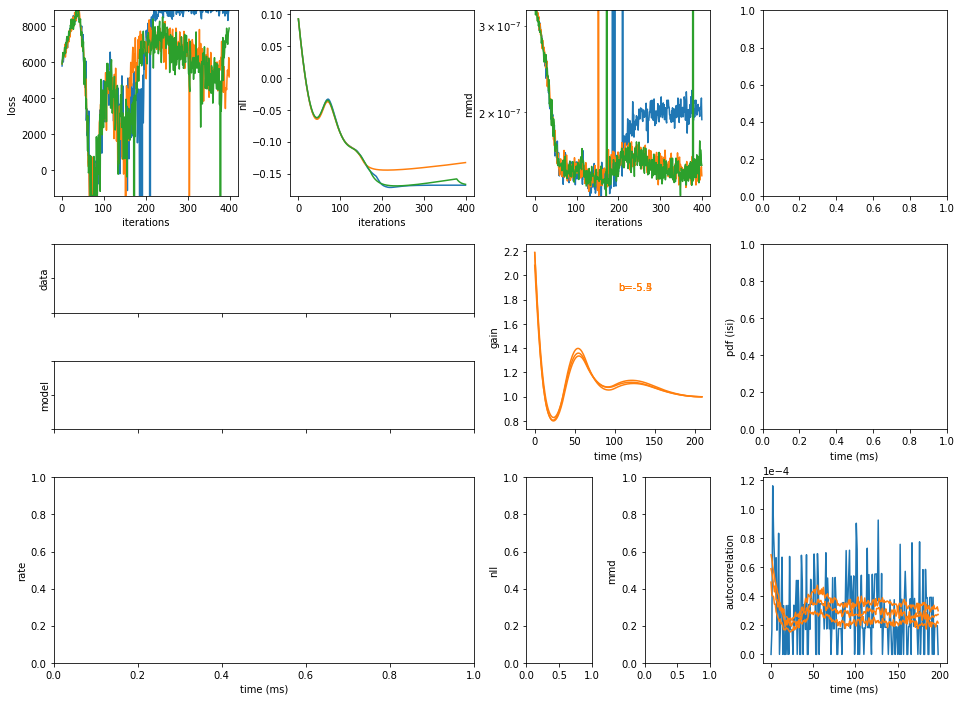

In [44]:
label = 'MMD'
color ='C1'
fig, (axloss, axnlli, axmmdi, axextra, axd, axfr, axeta, axisi, axpsth, axnll, axmmd, axac) = plot_layout_fit()

axac.plot(autocor_val[1:argf_autocorr], color=palette['d'], label='data')

for ii in range(len(data)):
    path = '/home/diego/storage/projects/generative-glm/experiments/figure4/' + data.iloc[ii].file_name
    ker_name, loss_mmd, mmdi, nll_normed_train_mmd, glm, autocor_mmd = load_file(path, t=t)
    plot_fit(loss_mmd=loss_mmd, nll_normed_train_mmd=nll_normed_train_mmd, mmdi=mmdi, glm=glm, autocov_mmd=autocor_mmd, argf_autocorr=argf_autocorr, 
         axloss=axloss, axnlli=axnlli, axmmdi=axmmdi, axextra=axextra, axd=axd, axfr=axfr, axeta=axeta, axisi=axisi, axpsth=axpsth, axnll=axnll, axmmd=axmmd, axac=axac, label=None, color=None);

In [ ]:
fig, (axeta, axll_train, axfra, axfrb, axlabels, axcia, axcib, axll_val, axmuisi, axcv, axac) = plot_layout(figsize=(18, 5))

In [ ]:
list_files = os.listdir(files_folder)

In [17]:
ker_type = 'cimmd_autocov'
float_lam = '5000.0'
biased = True
lam_mmd = 5e3
n_epochs, lr = 300, 0.01

pk_files = [pkf for pkf in list_files if pkf[-3:]== '.pk' and ker_type in pkf and 'lammmd' + float_lam in pkf \
            and 'biased' + str(biased) in pkf and 'epochs' + str(n_epochs) in pkf and 'lr' + str(lr) in pkf]

In [2]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
path = "/home/diego/python/generative-glm/cool_stuff/p110509b_dots_mat_diego.h5"
f = h5py.File(path, "r")

mask_spikes = np.array(np.stack((f['spk']), axis=1), dtype=bool)
dt = 1
t = np.arange(0, mask_spikes.shape[0], 1)
T = t[-1] - t[0] + t[1]

In [4]:
from cycler import cycler

mpl.rcParams['axes.prop_cycle'] = cycler(color=['#CD4545', 'dodgerblue', '#ff7f0e', '#9467bd', 
                                                            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

In [5]:
def broken_yaxis(ax1, ax2, d=0.15):
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
#     ax1.xaxis.tick_top()
    ax1.tick_params(axis='x', labeltop=False, labelbottom=False, length=0, width=0)
#     ax1.set_xticks([])
#     ax2.xaxis.tick_bottom()
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
#     kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
#     ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# #     ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

#     kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#     ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#     ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    return ax1, ax2

In [6]:
def plot_layout(figsize):
    r1, c1 = 6, 2
    r2, c2 = 3, 1
    r2a, r2b = 1, 2
    nrows, ncols = r1, c1 + 4 * c2
    fig = plt.figure(figsize=figsize)
    axeta = plt.subplot2grid((nrows, ncols), (0, 0), rowspan=nrows, colspan=c1)
    ax00 = plt.subplot2grid((nrows, ncols), (0, c1), rowspan=r2, colspan=c2)
#     ax01 = plt.subplot2grid((nrows, ncols), (0, c1 + c2), rowspan=r2, colspan=c2)
    ax01a = plt.subplot2grid((nrows, ncols), (0, c1 + c2), rowspan=r2a, colspan=c2)
    ax01b = plt.subplot2grid((nrows, ncols), (r2a, c1 + c2), rowspan=r2b, colspan=c2, sharex=ax01a)
    broken_yaxis(ax01a, ax01b)
    ax02 = plt.subplot2grid((nrows, ncols), (0, c1 + 3 * c2), rowspan=r2, colspan=c2)
#     ax03 = plt.subplot2grid((nrows, ncols), (0, c1 + 3 * c2), rowspan=r2, colspan=c2)
    ax03a = plt.subplot2grid((nrows, ncols), (0, c1 + 2 * c2), rowspan=r2a, colspan=c2)
    ax03b = plt.subplot2grid((nrows, ncols), (r2a, c1 + 2 * c2), rowspan=r2b, colspan=c2, sharex=ax03a)
    broken_yaxis(ax03a, ax03b)
    ax10 = plt.subplot2grid((nrows, ncols), (r2, c1), rowspan=r2, colspan=c2, sharey=ax00)
    ax11 = plt.subplot2grid((nrows, ncols), (r2, c1 + c2), rowspan=r2, colspan=c2)
    ax12 = plt.subplot2grid((nrows, ncols), (r2, c1 + 2 * c2), rowspan=r2, colspan=c2)
    ax13 = plt.subplot2grid((nrows, ncols), (r2, c1 + 3 * c2), rowspan=r2, colspan=c2)
    return fig, (axeta, ax00, ax01a, ax01b, ax02, ax03a, ax03b, ax10, ax11, ax12, ax13)

# plot_layout((10, 8))

In [9]:
# u_dc_val, r_dc_val = mmdglm.sample_conditioned(t, mask_spikes_val)
# u_fr, r_fr, mask_spikes_fr = mmdglm.sample(t, shape=(n,))
# ci_mse = np.mean((np.mean(r_dc_val, 1) - np.mean(r_fr, 1))**2)

In [10]:
dic_labels = {'mmd_autocov': "$<C_{x}, C_{x'}>$", 'mmd_gaussian': r"$\exp(-(\nu_x - \nu_{x'})^2 / \sigma )$", 
              'cimmd_gaussian': r"$\exp(-\sum(\lambda - \lambda')^2 / \sigma )$",
    'cimmd_means': "$ \mu[\lambda], \mu[\lambda'] $", 'cimmd_autocov': "$ <C_{H_x}, C_{H_{x'}}> $"}

In [45]:
#             'mmd_gaussian_fr_lammmd10000.0biasedTrue_epochs600_lr0.01_2.pk', # almost stable
#             'mmd_gaussian_fr_lammmd20000.0biasedTrue_epochs600_lr0.01_1.pk', # almost stable

pk_files = [ 
            
            # gaussian_fr
            'mmd_gaussian_fr_lammmd10000.0biasedTrue_epochs400_lr0.05_1.pk', # stable
            'mmd_gaussian_fr_lammmd50000.0biasedTrue_epochs600_lr0.01_1.pk', # interistingly stable
    
            # autocov spikes. need more of this
            'mmd_autocov_lammmd10000.0biasedTrue_epochs1000_lr0.002_1.pk',
#             'mmd_gaussian_fr_autocov_lammmd1.0biasedTrue_epochs1000_lr0.01_1.pk', # placeholder for a good one of this
#             'mmd_gaussian_fr_autocov_lammmd1.0biasedTrue_epochs1000_lr0.01_3.pk', 
    
            # mean_CI
            'cimmd_means_product_lammmd5000.0biasedTrue_epochs1000_lr0.01_1.pk', #stable
    
            # gaussian_CI
#             'cimmd_gaussian_lammmd5000.0biasedTrue_epochs400_lr0.01_1.pk', # stable. gives similar results as mean_CI 1st file
    
            # kill the belly in the end
              'cimmd_autocov_lammmd5000.0biasedTrue_epochs300_lr0.01_1.pk', # stableeeee
#             'cimmd_autocov_lammmd500.0biasedTrue_epochs400_lr0.01_1.pk', #unstable
#             'cimmd_autocov_lammmd5000.0biasedTrue_epochs400_lr0.01_1.pk', #unstable
#             'cimmd_autocov_lammmd5000.0biasedTrue_epochs750_lr0.01_3.pk', #unstable
#             'cimmd_autocov_lammmd10000.0biasedTrue_epochs400_lr0.01_2.pk', #unstable
    
            # kill the belly in the beginning
#             'cimmd_autocov_lammmd700.0biasedTrue_epochs500_lr0.01_1.pk' #unstable
#             'cimmd_autocov_lammmd1000.0biasedTrue_epochs600_lr0.01_1.pk' # file lost
    
    #             'mmd_autocov_lammmd100000.0biasedTrue_epochs1000_lr0.002_1.pk',
            ]

# fig, (axeta, ax01, ax02, ax03) = plt.subplots(figsize=(15, 5), ncols=4)
# ax00, ax01a, ax01b, ax02, ax03a, ax03b, ax10, ax11, ax12, ax13
fig, (axeta, axll_train, axfra, axfrb, axlabels, axcia, axcib, axll_val, axmuisi, axsdisi, axac) = plot_layout(figsize=(18, 5))
fig.subplots_adjust(hspace=0.8, wspace=0.9)


t_ker = np.arange(0, 137, 1)

axbias = inset_axes(axeta, width=1.1, height=0.5, bbox_to_anchor=(0, 0, .9, .8),
                   bbox_transform=axeta.transAxes)
# myplt.set_labels(axbias, xlabel='', ylabel='exp(b) (Hz)')
axbias.set_ylabel('exp(b) (Hz)', fontsize=tick_labelsize)
axbias.set_yticks([0, 2, 4])
# axbias.set_yticks([0, 5e-3])
# axins1.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useOffset=False)
# axbias.tick_params(axis='both', labelsize=12)
# axbias.set_ylim(-5e-3, 1e-2)

widths = 0.8

x0 = -0.5

with open(root_folder + pk_files[0], "rb") as fit_file:
    pk = pickle.load(fit_file)
    offset = 100
    n_train, n_val = pk['n_train'], pk['n_val']
    mask_spikes_train = mask_spikes[:, :offset + n_train]
    n_spk_train = np.sum(mask_spikes_train)
    nll_pois_proc_train = bernoulli_log_likelihood_poisson_process(mask_spikes_train)
#     mask_spikes_val = mask_spikes[:, offset + n_train:offset + n_train + n_val]
    mask_spikes_val = mask_spikes[:, 200:400]
    st_val = SpikeTrain(t, mask_spikes_val)
    isi_val = st_val.isi_distribution()
    n_spk_val = np.sum(mask_spikes_val)
    fr_val = np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000
    mu_fr_val = np.mean(fr_val)
    nll_pois_proc_val = bernoulli_log_likelihood_poisson_process(mask_spikes_val)
    autocor_val = np.mean(auto_covariance(mask_spikes_val, method='fft', subtract_mean=False, 
                                            stationary_signal=False, biased=False), 1)
    autocor_val = autocor_val[:250]
    
    axfra.boxplot(fr_val, positions=[0], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor=palette['d']), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    axfrb.boxplot(fr_val, positions=[0], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor=palette['d']), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    violinplot(axmuisi, isi_val, 0, widths=widths, showmeans=True, color=palette['d'])
    axlabels.text(x0, 0.9, 'd: data', transform=axlabels.transAxes, color=palette['d'], fontsize=16, 
                  horizontalalignment='left', verticalalignment='center')
#     parts = axmuisi.violinplot(isi_val, positions=[0], widths=widths, showmeans=True)
#     for pc in parts['bodies']:
#         pc.set_facecolor(palette['d'])
#         pc.set_edgecolor(palette['d'])
#         pc.set_alpha(1)
        
    axsdisi.bar(0, np.std(isi_val) / np.mean(isi_val), color=palette['d'])
    
    eta_ml = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=pk['eta_coefs_ml'])
    glm_ml = GLM(u0=pk['u0_ml'], eta=eta_ml)
#     ax00.bar(0, glm.u0, color=palette['ml'])
    axbias.bar(1, np.exp(glm_ml.u0) * 1000, color=palette['ml'])
    glm_ml.eta.plot(t=t_ker, ax=axeta, exp_values=True, lw=2, color=palette['ml'])

    ll_train_ml, ll_ml, fr_ml, mu_fr_fr, ci_mse, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, autocor_mse = observables(glm_ml)
#     u_dc_ml, r_dc_ml = glm_ml.sample_conditioned(t, mask_spikes_val)
#     u_fr_ml, r_fr_ml, mask_spikes_ml = glm_ml.sample(t, shape=(n,))
#     st_fr_ml = SpikeTrain(t, mask_spikes_ml)
#     isi_fr_ml = st_fr_ml.isi_distribution()
#     mean_isi_fr_ml = np.mean()
#     ll_ml= np.sum(np.log(1 - np.exp(-dt * r_dc_ml[mask_spikes_val]) + 1e-24) ) - \
#                 dt * np.sum(r_dc_ml[~mask_spikes_val])
#     ll_ml = (ll_ml - nll_pois_proc_val) / np.log(2) / n_spk_val

#     fr_ml = np.mean(np.sum(mask_spikes_ml, 0) / T) * 1000
    
    axll_train.bar(1, ll_train_ml, color=palette['ml'])
    axll_val.bar(1, ll_ml, color=palette['ml'])
#     axfr.bar(0, mu_fr_fr, color=palette['ml'])
    axfra.boxplot(fr_ml, positions=[1], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor=palette['ml']), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    axfrb.boxplot(fr_ml, positions=[1], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor=palette['ml']), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
    print('number outliers', np.sum(fr_ml > 100), 'out of', len(fr_ml))
#     axsdfr.bar(0, sd_fr_fr, color=palette['ml'])
#     axmuisi.bar(0, mean_isi_fr_ml, color=palette['ml'])
    violinplot(axmuisi, isi_fr, 1, widths=widths, showmeans=True, color=palette['ml'])
    axsdisi.bar(1, sd_isi_fr / mu_isi_fr, color=palette['ml'])
    axcia.bar(1, ci_mse, color=palette['ml'])
    axcib.bar(1, ci_mse, color=palette['ml'])
    axac.bar(1, autocor_mse, color=palette['ml'])
    axlabels.text(x0, 0.9 - 0.15, '0: MLE', transform=axlabels.transAxes, color=palette['ml'], fontsize=16, 
                  horizontalalignment='left', verticalalignment='center')
        
for ii, pk_f in enumerate(pk_files):
    with open(root_folder + pk_f, "rb") as fit_file:
        pk = pickle.load(fit_file)
        print(ii + 1, 'n_batch_fr', pk['n_batch_fr'])
        eta_mmd = KernelBasisValues(pk['basis'], [0, pk['basis'].shape[0]], 1, coefs=pk['eta_coefs_mmd'])
        mmdglm = GLM(u0=pk['u0_mmd'], eta=eta_mmd)
#         ax00.bar(ii + 1, mmdglm.u0)
        axbias.bar(ii + 2, np.exp(mmdglm.u0) * 1000)
        mmdglm.eta.plot(t=t_ker, exp_values=True, ax=axeta)
        
#         ll_val, fr_fr, mean_isi_fr, var_isi_fr = observables(mmdglm)
        ll_train, ll_val, fr, mu_fr_fr, sd_fr_fr, isi_fr, mu_isi_fr, sd_isi_fr, ci_mse, autocor_mse = observables(mmdglm)
        print('number outliers', np.sum(fr > 100), 'out of', len(fr))
        
        axll_train.bar(ii + 2, ll_train)
        axll_val.bar(ii + 2, ll_val)
#         axfr.bar(ii + 1, mu_fr_fr)
#         sns.boxplot(x=np.zeros(len(fr)) + ii + 1, y=fr, ax=axfr)
        axfra.boxplot(fr, positions=[ii + 2], patch_artist=True, widths=widths, showmeans=True, meanline=True, 
                          boxprops=dict(facecolor='C' + str(ii)), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
        axfrb.boxplot(fr, positions=[ii + 2], patch_artist=True, widths=widths,showmeans=True, meanline=True, 
                          boxprops=dict(facecolor='C' + str(ii)), 
                          meanprops=dict(color='k'), 
                          medianprops=dict(color='k'))
#         axsdfr.bar(ii + 1, sd_fr_fr)
        violinplot(axmuisi, isi_fr, ii + 2, widths=widths, showmeans=True, color='C' + str(ii))
#         axmuisi.bar(ii + 1, mu_isi_fr)
        axsdisi.bar(ii + 2, sd_isi_fr / mu_isi_fr)
        axcia.bar(ii + 2, ci_mse)
        axcib.bar(ii + 2, ci_mse)
        axac.bar(ii + 2, autocor_mse)
        label = '_'.join(pk_f.split('_')[:2])
#         axlabels.text(0.1, 0.9 - 0.1 * ii, "$\lambda \lambda'$", transform=axsdfr.transAxes)
        if ii == 0:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label] + r'  $\alpha$=' \
                          + '$1e^4$', transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')
        elif ii == 1:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label] + r'  $\alpha$=' \
                          + '$5e^4$', transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')
        else:
            axlabels.text(x0, 0.9 - 0.15 * (ii + 2), str(ii + 1) + ': ' + dic_labels[label], transform=axlabels.transAxes, 
                      color='C' + str(ii), fontsize=16, horizontalalignment='left', verticalalignment='center')

myplt.set_labels(axeta, xlabel='time (ms)', ylabel='gain', title='history filter')
# axeta.legend(frameon=False)
axeta.plot([t_ker[0], t_ker[-1]], [1, 1], 'k--', alpha=0.5, lw=1)
axeta.set_xscale('log')

myplt.set_labels(axll_train, ylabel='train log-L')
myplt.set_labels(axll_val, ylabel='val log-L')

yfr_0a = 50
# axfra.set_yticks([])
axfra.set_ylim(yfr_0a, 1000)
axfra.set_yscale('log')
axfra.get_yaxis().set_minor_formatter(ticker.NullFormatter())
# axfra.get_yaxis().get_major_formatter().labelOnlyBase = False
# 
# axfra.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

yfr_fb = 17
# myplt.set_labels(axfrb, ylabel='firing rate (Hz)')
axfrb.set_ylabel('firing rate (Hz)')
axfrb.set_ylim(-0.5, yfr_fb)
axfrb.yaxis.set_label_coords(-0.4, 0.9)

# myplt.set_labels(axsdfr, ylabel='sd firing rate (Hz)')
myplt.set_labels(axmuisi, ylabel='isi (ms)')
myplt.set_labels(axsdisi, ylabel='cv isi')

y0a = 10
axcia.set_yscale('log')
axcia.set_ylim(y0a, 1e15)

yfb = 1e-6
# axcib.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
axcib.set_yscale('log')
axcib.set_ylim(1e-8, yfb)
axcib.yaxis.set_label_coords(-0.5, 0.9)

axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
myplt.set_labels(axcib, ylabel='$\sum (\lambda_{dc} - \lambda_{fr})^2/T$')

# axsdfr.text(0.1, 0.1, '$\bar{\lambda} \bar{\lambda}$', transform=axsdfr.transAxes)

myplt.set_labels(axac, ylabel='rmse autocor')
axac.set_yscale('log')
axac.set_yticks([1e-4, 1e-3])
# axac.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

for ax in (axbias, axll_train, axfra, axfrb, axcia, axcib, axll_val, axmuisi, axsdisi, axac):
    ax.set_xticks(range(ii + 3))
    ax.set_xticklabels(['d', '0'] + list(range(1, ii + 2)))
#     ax.set_xticks(range(2, ii + 3))
#     ax.set_xticklabels(list(range(1, ii + 2)))
    ax.set_xlim(-1, ii + 3)
    
myplt.set_scale_bars(axlabels)

for ax in (axbias, axll_train, axcib, axll_val, axac):
#     yf = axll_train.get_ylim()[1] / 2
#     ax.text(0, yf, 'n/a', color=palette['d'], fontsize=16, horizontalalignment='center', 
#             verticalalignment='center')
    ax.text(0.1, 0.5, 'N\nA', color=palette['d'], fontsize=14, horizontalalignment='center', 
            verticalalignment='center', transform=ax.transAxes)

# fig.savefig('/home/diego/Dropbox/generative_glm/figures/fig4.pdf', transparent=True)

NameError: name 'plot_layout' is not defined

Text(0.5, 0.5, '$\\alpha$')

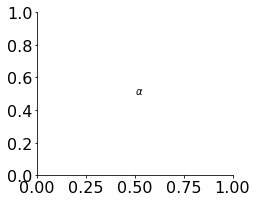

In [373]:
fig, ax = plt.subplots()
ax.text(0.5, 0.5, r"$\alpha$")